# Modified equation to to keep real tax rates 
Sometime we want to modify an existing model without starting from scratch. Modelflow
allows to modify models replace, add or delete equations. 

In this notebook the Pakistan model is modified so that a the tax rates on CO2 emission 
is kept constant in real terms. 

## Import the model class
This class incorporates most of the methods used to manage a model. 

In [1]:
 %load_ext autoreload
 %autoreload 2

In [2]:
from modelclass import model 
model.widescreen()
model.scroll_off()

## Load a pre-existing model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions. 

In [3]:
mpak,exostart = model.modelload('../../models/pak_exogenized.pcim',run=1,silent=1)
mpakdisplay,_ = model.modelload('../../models/pak.pcim',run=1,silent=1)   # to have a model in store 

In [4]:

# the variables with a description are extracted
# Theese are the interesting variables 

desvar = [v for v,d in mpak.var_description.items() if v != d]
mpak.var_description

{'PAKBMFSTCABTCD': 'Imports Factor Services and Transfers',
 'PAKBMFSTINTECD': 'Interest Payments',
 'PAKBMGSRNFSVCD': 'Imports Services',
 'PAKBNCABFUNDCD': 'Current account balance (USD)',
 'PAKBNFSTCABTCD': 'Factor Services and Transfers (Primary and Secondary Incomes)',
 'PAKBNGSRGNFSCD': ' Net Trade',
 'PAKBXFSTCABTCD': 'Exports Factor Services and Transfers',
 'PAKBXGSRNFSVCD': 'Exports Services',
 'PAKCFVOLUMECN': 'Volume of contingency fund, current prices',
 'PAKCFVOLUMEKN': 'Volume of contingency fund, constant prices',
 'PAKDISPREPCN': 'Investment in disaster risk preparation, current prices',
 'PAKDISPREPKN': 'Investment in disaster risk preparation, constant prices',
 'PAKFMLBLMTWOCN': 'Nominal money supply',
 'PAKGGBALOVRLCN': 'General government balance, LCU',
 'PAKGGBALPRIMCN': 'General government primary balance, LCU',
 'PAKGGEXPINTDCN': 'Interest Payments (Domestic)',
 'PAKGGEXPINTECN': ' Interest Payments (External)',
 'PAKGGEXPINTPCN': 'Expenditure on Interest Payme

# Now update the mpak model so the carbon tax is keept konstant in real terms
PAKGGREVCO2CER is now determined by an equation which makes its growth rate follow the growth rate of PAKNECONPRVTXN (GDP)

Thus a new model is created. 

In [5]:
mpakreal,real_exostart = mpak.equpdate('''\
<exo> PAKGGREVCO2CER = PAKGGREVCO2CER(-1) * PAKNECONPRVTXN(-1) / PAKNECONPRVTXN(-2)
<exo> PAKGGREVCO2OER = PAKGGREVCO2OER(-1) * PAKNECONPRVTXN(-1) / PAKNECONPRVTXN(-2)
<exo> PAKGGREVCO2GER = PAKGGREVCO2GER(-1) * PAKNECONPRVTXN(-1) / PAKNECONPRVTXN(-2)
''',add_add_factor=False, calc_add=False,newname='Pak model, real adjusted tax')


The model:"pak model" got new equations, new model name is:"Pak model, real adjusted tax"
New equation for For PAKGGREVCO2CER
Old frml   :new endogeneous variable 
New frml   :FRML <exo> PAKGGREVCO2CER = PAKGGREVCO2CER(-1)*PAKNECONPRVTXN(-1)/PAKNECONPRVTXN(-2)$
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2OER
Old frml   :new endogeneous variable 
New frml   :FRML <exo> PAKGGREVCO2OER = PAKGGREVCO2OER(-1)*PAKNECONPRVTXN(-1)/PAKNECONPRVTXN(-2)$
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2GER
Old frml   :new endogeneous variable 
New frml   :FRML <exo> PAKGGREVCO2GER = PAKGGREVCO2GER(-1)*PAKNECONPRVTXN(-1)/PAKNECONPRVTXN(-2)$
Adjust calc:No frml for adjustment calc  



## for later make some lists with variable names

In [6]:
taxvar  = mpakreal.vlist('PAKGGREVCO2???')   # define lists of the relevant variables. 
taxexo = mpakreal.vlist('PAKGGREVCO2???_X')
taxdummy = mpakreal.vlist('PAKGGREVCO2???_D')
taxall   = taxvar+taxexo+taxdummy
lookat_years = [2019,2020,2021,2022,2025,2026,2098,2099,2100]

# Run the nominal model with no additional tax (the baseline) and with a tax of 29 \$ 

## Create a dataframe where tax is set to 29

In [7]:
nominal_CT= exostart.copy()   # A clean dataframe 
value = 29

nominal_CT.loc[2020:2100,taxvar] = value 
nominal_CT.loc[lookat_years,taxvar]   # show the values 

,PAKGGREVCO2CER,PAKGGREVCO2GER,PAKGGREVCO2OER
2019,-5.549839,-41.000884,-8.71065
2020,29.000000,29.000000,29.00000
2021,29.000000,29.000000,29.00000
2022,29.000000,29.000000,29.00000
2025,29.000000,29.000000,29.00000
2026,29.000000,29.000000,29.00000
2098,29.000000,29.000000,29.00000
2099,29.000000,29.000000,29.00000
2100,29.000000,29.000000,29.00000


# Run the model with the baseline and with the nominal tax 

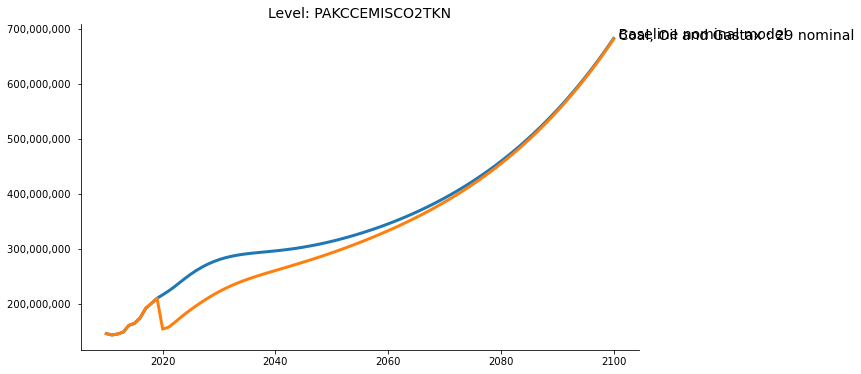

In [8]:
mpak.keep_solutions={}   # 
res_no_tax   = mpak(exostart,2020,2100,alfa = 0.7,keep=f'Baseline nominal model')
res_nominal  = mpak(nominal_CT,2020,2100,alfa = 0.7,keep=f'Coal, Oil and Gastax : {value} nominal')
mpak.keep_plot('PAKCCEMISCO2TKN',2010,2100);

# Now perform the same exercise but holding the oil price constant in ex ante real terms

## the values in the baseline
We assume unchanged tax

In [9]:
real_basestart = real_exostart.copy() 
real_basestart.loc[2020:2100,taxdummy ] = 1         # the tax is fixed until 25 
real_basestart.loc[2020:2100,taxexo] = real_basestart.loc[2020:2100,taxvar ].values # keep the tax until 24

ValueError: shape mismatch: value array of shape (81,3) could not be broadcast to indexing result of shape (0,81)

In [ ]:

real_basestart.loc[lookat_years,taxvar+taxexo+taxdummy] # 


# update the real dataframe 
tax unchanged until 2025 where it is set to 29. after this the real model is used to adjust the taxrates

In [ ]:
real_CT = real_exostart.copy() 
real_CT.loc[2020:2025,taxdummy ] = 1         # the tax is fixed until 25 
real_CT.loc[2020:2024,taxexo] = real_CT.loc[2020:2024,taxvar ].values # keep the tax until 24
real_CT.loc[2025,taxexo] = value             # set the tax in 25                       
real_CT.loc[lookat_years,taxall]

# Run the real model 

In [ ]:
mpakreal.keep_solutions={}   # 
res_no_tax_real   = mpakreal(real_basestart,2020,2100,alfa = 0.7,keep=f'Baseline real model')
res_real          = mpakreal(real_CT,       2020,2100,alfa = 0.7,keep=f'Coal, Oil and Gastax : {value} real')
mpakreal.keep_plot('PAKCCEMISCO2TKN',2010,2100);

# review the different relevant tax variables

In [ ]:
res_real.loc[lookat_years,taxall]

# Display the changes in exogeneous variable between the baseline and the alternative scenario


In [ ]:
mpakreal.exodif()

# Now look at the results for the two models. 

In [ ]:
mpakdisplay.keep_solutions = {**mpak.keep_solutions,**mpakreal.keep_solutions}
mpakdisplay.keep_solutions.keys()

In [ ]:
with mpakdisplay.keepswitch(scenarios='Co*'):
    mpakdisplay.keep_plot('PAKCCEMISCO2TKN',2016,2100,diff=0,legend=0);

In [ ]:
with mpakdisplay.keepswitch(scenarios='B*'):
    mpakdisplay.keep_plot('PAKCCEMISCO2TKN',2016,2100,diff=1,legend=0);